# CIS519 Trained Model Ensemble and Inference

## Boostrap

In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import time
from datetime import datetime
import os
import io
import boto3
from io import BytesIO
import sagemaker
from sagemaker import get_execution_role

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import torchvision as tv
import torchvision.transforms as T
import torchvision.models as M
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
from PIL import Image
import random
from tqdm import tqdm

from torch.cuda.amp import autocast, GradScaler
from datetime import datetime
import pytz
import timm

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [5]:
%%time
# Set the timezone to Pacific Time
pt = pytz.timezone('America/Los_Angeles')

role = get_execution_role()
print(role)

region = boto3.Session().region_name
sess = sagemaker.Session()

arn:aws:iam::968333200412:role/SageMakerExecutionRole
CPU times: user 284 ms, sys: 28.5 ms, total: 312 ms
Wall time: 425 ms


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
s3_client = boto3.client('s3')

# List all the buckets
response = s3_client.list_buckets()

# Print the name of each bucket
for bucket in response['Buckets']:
    print(bucket['Name'])
    bucket_name = bucket['Name']

# List all the folders (prefixes) inside the bucket
response = s3_client.list_objects_v2(Bucket=bucket_name, Delimiter='/')

file_path = 'dataset/train.csv'
train_csv_obj = s3_client.get_object(Bucket=bucket_name, Key=file_path)
train_df =pd.read_csv(io.BytesIO(train_csv_obj['Body'].read()))
train_df.head()

519bucket


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [8]:
read_file_from_s3 = lambda file_path: s3_client.get_object(Bucket=bucket_name, Key=file_path)['Body']

pd.read_csv(read_file_from_s3('dataset/train.csv'))

# Print labels and category encodings
path_prefix = 'dataset/'

# Load data
train = pd.read_csv('clean_train_df.csv')
test = pd.read_csv(read_file_from_s3('dataset/sample_submission.csv'))
label_map = pd.read_json(read_file_from_s3('dataset/label_num_to_disease_map.json'), orient='index')

## Dataset

In [9]:
# Define basic transformation and augmentation
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

class CassavaDataset(Dataset):
    def __init__(self, csv_path, s3_prefix, transform=None):
        self.data = pd.read_csv(csv_path)
        self.s3_prefix = s3_prefix
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = f"{self.s3_prefix}/{row['image_id']}"
        #now doing good thing
        image_bytes = read_file_from_s3(image_path)
        image = Image.open(image_bytes).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = row['label']
        return image, label
        
train_data_path = 'clean_train_df.csv'
s3_prefix = 'dataset/train_images'
dataset = CassavaDataset(train_data_path, s3_prefix, transform=transform)

In [10]:
# Train test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Load data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Models

In [11]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super(ResNet, self).__init__()
        
        # Load pretrained ResNet18
        self.resnet = M.resnet18(pretrained=pretrained)
        
        # Replace last fully connected layer with new layer for custom number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # Forward pass through ResNet18 layers
        x = self.resnet(x)
        return x


class VitClassifier(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", n_classes=5, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, n_classes)
        self.best_val_loss = float('inf')  # initialize best validation loss to infinity
        self.early_stopping_rounds = 3  # number of epochs to wait before early stopping
        self.epochs_without_improvement = 0  # number of epochs without improvement
        self.scaler = GradScaler()  # initialize GradScaler
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def evaluate(self, loader, criterion, device):
        self.model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                val_loss += criterion(output, target).item()
                val_acc += (output.argmax(1) == target).sum().item()

        val_loss /= len(loader)
        val_acc /= len(loader.dataset)
        return val_loss, val_acc
    
    def train_one(self, loader, optimizer, criterion, device, val_loader=None):
        self.model.train()
        train_loss = 0
        train_acc = 0
        pbar = tqdm(enumerate(loader), total=len(loader))
        for step, batch in pbar:
            optimizer.zero_grad()
            data, target = batch
            data, target = data.to(device), target.to(device)

            with autocast():
                output = self.model(data)
                loss = criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(optimizer)
            self.scaler.update()

            train_loss += loss.item()
            train_acc += (output.argmax(1) == target).sum().item()

        train_loss /= len(loader)
        train_acc /= len(loader.dataset)

        if val_loader is not None:
            val_loss, val_acc = self.evaluate(val_loader, criterion, device)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.early_stopping_rounds:
            print(f'Validation loss has not improved in {self.early_stopping_rounds} epochs. Early stopping...')
            return train_loss, train_acc, True
        else:
            return train_loss, train_acc, False

## Evaluation

In [12]:
def evaluate(model, test_loader):
    model.to("cuda")
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    correct = 0
    total = 0
    preds = np.array([])
    labels = np.array([])
    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            preds = np.concatenate([preds, predicted.cpu().numpy()])
            labels = np.concatenate([labels, targets.cpu().numpy()])

    test_acc = 100 * correct / total
    print('Test accuracy: %d %%' % test_acc)

    return preds, labels, test_acc

In [13]:
cnn = BasicCNN(num_classes=5).to(device)
cnn.load_state_dict(torch.load("models/cnn-04_53.pth"))

<All keys matched successfully>

In [14]:
# Evaluate the model on the test data
print("evaluate CNN")
cnn_preds, cnn_labels, cnn_test_acc = evaluate(cnn, test_loader)

evaluate CNN


100%|██████████| 61/61 [02:54<00:00,  2.85s/it]

Test accuracy: 67 %


In [15]:
vit = VitClassifier(model_name="vit_base_patch16_224", n_classes=5, pretrained=False).to(device)
state_dict = torch.load("models/vit_23_29_epoch_2.pth")
vit.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
print("evaluate vit")
vit_preds, vit_labels, vit_test_acc = evaluate(vit, test_loader)

evaluate vit


100%|██████████| 61/61 [02:57<00:00,  2.91s/it]

Test accuracy: 88 %


In [17]:
rnet = ResNet(num_classes=5)
rnet.resnet.load_state_dict(torch.load("models/resnet18-20_03.pth"))
rnet.resnet.to(device)
rnet.to(device)

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [18]:
print("evaluate resnet")
rn_preds, rn_labels, rn_test_acc = evaluate(rnet, test_loader)

evaluate resnet


100%|██████████| 61/61 [02:38<00:00,  2.60s/it]

Test accuracy: 91 %


## Ensemble

In [72]:
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import torch.nn.functional as F
import torch
import torchvision.models as models
import torch.nn as nn

def evaluate_ensemble(models, test_loader):
    num_models = len(models)
    preds = [np.array([]) for _ in range(num_models)]
    labels = np.array([])
    ensemble_preds = np.array([])
    correct = [0] * num_models
    total = 0
    probs_labels = []

    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = [F.softmax(model(inputs), dim=1) for model in models]
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            _, predicted = torch.max(avg_output.data, 1)
            ensemble_preds = np.concatenate([ensemble_preds, predicted.cpu().numpy()])
            probs = F.softmax(avg_output, dim=1).cpu().numpy()
            probs_labels.extend(probs)

            total += targets.size(0)
            labels = np.concatenate([labels, targets.cpu().numpy()])

            for i in range(num_models):
                preds[i] = np.concatenate([preds[i], outputs[i].argmax(1).cpu().numpy()])
                correct[i] += (outputs[i].argmax(1) == targets).sum().item()

            pbar.set_description('Evaluating ensemble')
    
    test_acc = [100 * correct[i] / total for i in range(num_models)]
    ensemble_acc = 100 * (ensemble_preds == labels).sum() / total

    print('Individual model accuracies:')
    for i in range(num_models):
        print('Model %d: %.2f %%' % (i, test_acc[i]))
    print('Ensemble accuracy: %.2f %%' % (ensemble_acc))
    
    precision = precision_score(labels, ensemble_preds, average='weighted')
    recall = recall_score(labels, ensemble_preds, average='weighted')
    f1 = f1_score(labels, ensemble_preds, average='weighted')
    print("precision ", precision)
    print("recall ", recall)
    print("f1 score ", f1)
     # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(labels, ensemble_preds)
    print(f"Confusion matrix:\n{conf_matrix}")
    
    return ensemble_preds, labels, probs_labels, ensemble_acc

In [90]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

def plotCurves(ensemble_preds, labels, probs_labels):
    probs_labels = np.array(probs_labels)
    # Compute ROC-AUC scores for each class
    auc_scores = []
    num_classes = 5

    for i in range(num_classes):
        true_labels_i = (np.array(labels) == i).astype(int)
        probs_i = probs_labels[:, i]
        auc_i = roc_auc_score(true_labels_i, probs_i)
        auc_scores.append(auc_i)
        print(f"Class {i}: AUC = {auc_i:.3f}")

    # Compute micro-averaged ROC-AUC score
    auc_micro = roc_auc_score(np.eye(num_classes)[labels.astype(int)], probs_labels, multi_class="ovr")
    print(f"Micro-averaged AUC = {auc_micro:.3f}")

    # Plot ROC curves for each class
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        true_labels_i = (np.array(labels) == i).astype(int)
        probs_i = probs_labels[:, i]
        fpr[i], tpr[i], _ = roc_curve(true_labels_i, probs_i)
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

    # Plot micro-averaged ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[labels.astype(int)].ravel(), probs_labels.ravel())
    plt.plot(fpr_micro, tpr_micro, label=f"Micro-averaged (AUC = {auc_micro:.2f})", linestyle="--")

    # Plot random classifier curve
    plt.plot([0, 1], [0, 1], "k--", label="Random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    #precision-recall
    #first binarize the labels
    bin_labels = label_binarize(labels, classes=[0, 1, 2, 3, 4])
    precision, recall, thresholds = precision_recall_curve(bin_labels.ravel(), probs_labels.ravel())
    pr_auc = auc(recall, precision)
    #precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
    plt.plot(recall, precision, label = {pr_auc})
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    print("PR_AUC is ", pr_auc)


In [92]:
models = [cnn, rnet, vit]
ensemble_preds, labels, probs_labels, ensemble_acc = evaluate_ensemble(models, test_loader)

Evaluating ensemble: 100%|██████████| 61/61 [03:13<00:00,  3.18s/it]

Individual model accuracies:
Model 0: 67.01 %
Model 1: 92.03 %
Model 2: 88.34 %
Ensemble accuracy: 92.29 %
precision  0.9259429717366491
recall  0.9229188078108942
f1 score  0.9201653059916738
Confusion matrix:
[[  89    1    0    3    4]
 [   8  174    0   13    6]
 [   5    2  163   50    9]
 [   1    1    0 1180    2]
 [   6    5    1   33  190]]


Class 0: AUC = 0.997
Class 1: AUC = 0.995
Class 2: AUC = 0.983
Class 3: AUC = 0.992
Class 4: AUC = 0.986
Micro-averaged AUC = 0.990


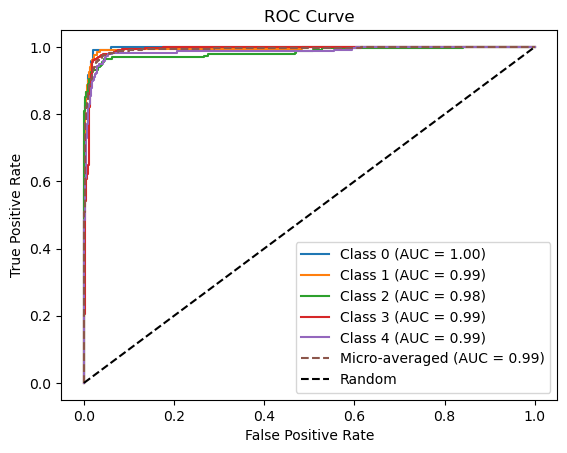

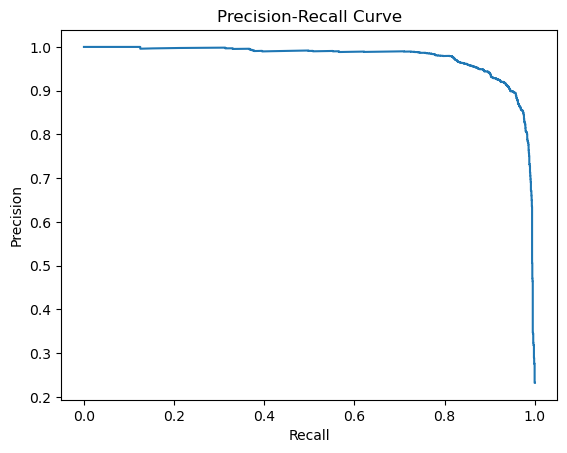

PR_AUC is  0.9751186121045881


In [93]:
plotCurves(ensemble_preds, labels, probs_labels)

In [94]:
models = [rnet, vit]
ensemble_preds, labels, probs_labels, ensemble_acc = evaluate_ensemble(models, test_loader)

Evaluating ensemble: 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]

Individual model accuracies:
Model 0: 92.09 %
Model 1: 88.34 %
Ensemble accuracy: 94.60 %
precision  0.9477089034818539
recall  0.9460431654676259
f1 score  0.9457536162903465
Confusion matrix:
[[  90    2    0    3    2]
 [   9  179    1    7    5]
 [   4    2  194   18   11]
 [   2    3    1 1172    6]
 [   9    4    0   16  206]]


Class 0: AUC = 0.997
Class 1: AUC = 0.995
Class 2: AUC = 0.991
Class 3: AUC = 0.996
Class 4: AUC = 0.990
Micro-averaged AUC = 0.994


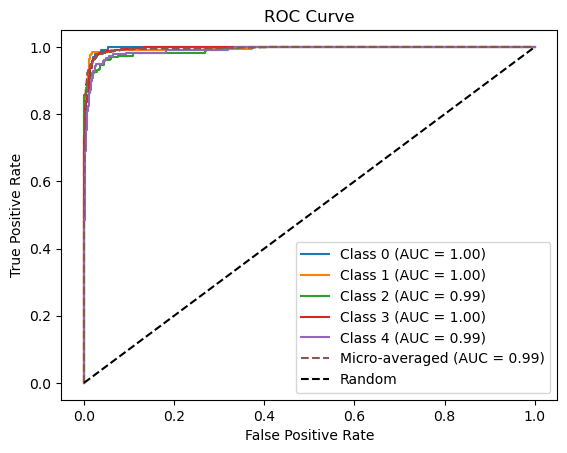

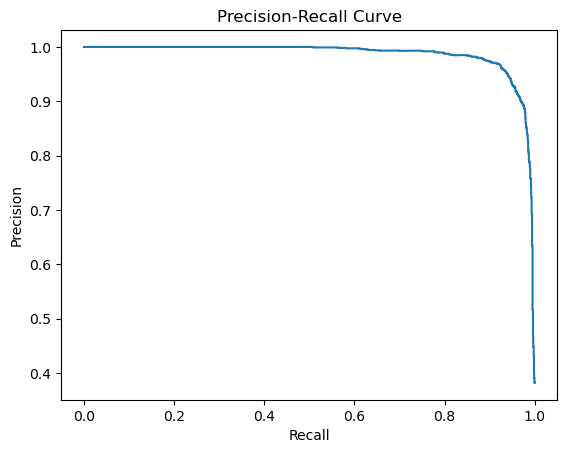

PR_AUC is  0.9858389125089304


In [95]:
plotCurves(ensemble_preds, labels, probs_labels)

## Ensemble TTA

In [41]:
tta_transform = [
    T.Resize(224),
    T.CenterCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
]


In [59]:
def evaluate_ensemble_tta(models, test_loader, tta_transform):
    num_models = len(models)
    preds = [np.array([]) for _ in range(num_models)]
    labels = np.array([])
    ensemble_preds = np.array([])
    correct = [0] * num_models
    total = 0

    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            if isinstance(inputs, torch.Tensor):
                inputs = inputs.permute(0, 2, 3, 1).cpu().numpy()
                inputs = [Image.fromarray(np.uint8(inputs[i] * 255)) for i in range(inputs.shape[0])]
            else:
                inputs = [transform(inputs) for transform in tta_transform]

            inputs_transformed = torch.stack([transforms.ToTensor()(img) for img in inputs]).to(device)

            outputs = [F.softmax(model(inputs_transformed), dim=1) for model in models]
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            _, predicted = torch.max(avg_output.data, 1)
            ensemble_preds = np.concatenate([ensemble_preds, predicted.cpu().numpy()])

            total += targets.size(0)
            labels = np.concatenate([labels, targets.cpu().numpy()])

            for i in range(num_models):
                preds[i] = np.concatenate([preds[i], outputs[i].argmax(1).cpu().numpy()])
                correct[i] += (outputs[i].argmax(1) == targets).sum().item()

            pbar.set_description('Evaluating ensemble')

    test_acc = [100 * correct[i] / total for i in range(num_models)]
    ensemble_acc = 100 * (ensemble_preds == labels).sum() / total

    print('Individual model accuracies:')
    for i in range(num_models):
        print('Model %d: %.2f %%' % (i, test_acc[i]))
    print('Ensemble accuracy: %.2f %%' % (ensemble_acc))

    return ensemble_preds, labels, ensemble_acc

In [60]:
models = [rnet, vit]
evaluate_ensemble_tta(models, test_loader, tta_transform)

Evaluating ensemble: 100%|██████████| 61/61 [03:19<00:00,  3.27s/it]

Individual model accuracies:
Model 0: 11.10 %
Model 1: 59.30 %
Ensemble accuracy: 45.84 %


(array([0., 1., 1., ..., 4., 3., 1.]),
 array([4., 4., 4., ..., 3., 3., 1.]),
 45.83761562178828)